In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None 
import json

In [2]:
# Obtenemos los datos previamente preparados
df = pd.read_csv('3_cleanedDataset2.csv', encoding = "utf-8")
print(df.shape)

# **CLASIFICACIÓN MEDIANTE MEANINGCLOUD**

In [ ]:
# Instalamos la libreria MeaningCloud
!pip install MeaningCloud-python
import meaningcloud

In [ ]:
# Añadimos algunas columnas donde extraeremos la información devuelta por el API
df['sentiment_mc'] = np.nan
df['confidence_mc'] = np.nan
df['irony_mc'] = np.nan
df['subjetivity_mc'] = np.nan

In [ ]:
# Definimos la función que obtendrá la polarida y otros datos, previamente debemos registrarnos en MeaningCloud y obtener la llave de licencia para empezar a utilizarlo
license_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'
for i in df.index: 
  sentiment_response = meaningcloud.SentimentResponse(meaningcloud.SentimentRequest(license_key, lang='es', txt=df['clean_content'][i], txtf='plain').sendReq())
  if sentiment_response.isSuccessful():
    df['sentiment_mc'][i] = sentiment_response.getGlobalScoreTag()
    df['confidence_mc'][i] = sentiment_response.getGlobalConfidence()
    df['irony_mc'][i] = sentiment_response.getIrony()
    df['subjetivity_mc'][i] = sentiment_response.getSubjectivity()

In [ ]:
# Verificamos los valores que arrojó el proceso anterior en la polaridad de los tweets
df['sentiment_mc'].value_counts()

In [ ]:
# Visualizamos la polaridad de los Tweets
plt.figure(figsize=(10,5)) 
df['sentiment_mc'].value_counts().plot(kind='bar',color = 'crimson')
plt.xlabel('Sentimiento')
plt.ylabel('Tweets')
plt.title('Polaridad de los Tweets')

In [ ]:
# Guardamos los datos con la polaridad previamente obtenida
import csv
df.to_csv('meaningCloudDataset2.csv', index=False)

# **ANÁLISIS DE SENTIMIENTO**

In [35]:
df2 = pd.read_csv('3_meaningCloudDataset2.csv', encoding = "utf-8")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10,11,12,22) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [36]:
print(df2.shape)
df2.head()

(16440, 33)


,id,date,user_id,user_username,user_displayname,user_created,user_followers_count,user_location,coordinates_latitude,coordinates_longitude,place_name,place_country,place_country_code,language,conversation_id,content,url,reply_count,retweeted_tweet,retweet_count,like_count,hashtags,cashtags,media,source,content_clean,length_tweet,number_words,sentiment_mc,confidence_mc,irony_mc,subjectivity_mc,entities_mc
0,1453125235549614080,2021-10-26 22:23:48+00:00,118461876,JRVilar,José Rafael Vilar,2010-02-28 19:28:57+00:00,671,Santa Cruz de la Sierra,NaN,NaN,NaN,NaN,NaN,es,1453125235549614080,"El 25/10, https://t.co/K0ob54N9yA informó 40.0...",https://twitter.com/JRVilar/status/14531252355...,1,NaN,0,0,NaN,NaN,NaN,Twitter Web App,El 25 10 Ratio x 100 hab total 62 1 En 270 día...,171,36,NONE,100.0,NONIRONIC,OBJECTIVE,[]
1,1453125237290283008,2021-10-26 22:23:48+00:00,118461876,JRVilar,José Rafael Vilar,2010-02-28 19:28:57+00:00,671,Santa Cruz de la Sierra,NaN,NaN,NaN,NaN,NaN,es,1453125235549614080,Inoculados ayer pauta completa (2ª dosis o uni...,https://twitter.com/JRVilar/status/14531252372...,1,NaN,0,0,NaN,NaN,NaN,Twitter Web App,Inoculados ayer pauta completa 2ª dosis o unid...,243,39,NEU,100.0,NONIRONIC,OBJECTIVE,"[{""form"": ""3 394 686"", ""id"": ""__18350811067469..."
2,1453125238959529984,2021-10-26 22:23:49+00:00,118461876,JRVilar,José Rafael Vilar,2010-02-28 19:28:57+00:00,671,Santa Cruz de la Sierra,NaN,NaN,NaN,NaN,NaN,es,1453125235549614080,Dosis llegadas hasta ayer: 15.076.036 dosis (S...,https://twitter.com/JRVilar/status/14531252389...,1,NaN,0,0,NaN,NaN,NaN,Twitter Web App,Dosis llegadas hasta ayer 15 076 036 dosis Spu...,262,44,NONE,100.0,NONIRONIC,OBJECTIVE,"[{""form"": ""Sputnik"", ""id"": ""0591cdc204"", ""type..."
3,1453125240771464960,2021-10-26 22:23:49+00:00,118461876,JRVilar,José Rafael Vilar,2010-02-28 19:28:57+00:00,671,Santa Cruz de la Sierra,NaN,NaN,NaN,NaN,NaN,es,1453125235549614080,Faltantes de inmunizar con pauta completa para...,https://twitter.com/JRVilar/status/14531252407...,0,NaN,0,0,NaN,NaN,NaN,Twitter Web App,Faltantes de inmunizar con pauta completa para...,268,49,NEU,100.0,NONIRONIC,OBJECTIVE,"[{""form"": ""Tambi\u00e9n SE"", ""id"": ""__11419840..."
4,1453061704103902976,2021-10-26 18:11:21+00:00,1391775741357007104,dexabot,Dexanfetamina,2021-05-10 15:23:12+00:00,1676,Santa Cruz de la Sierra,NaN,NaN,NaN,NaN,NaN,es,1453061704103902976,Me vacuné con la segunda de Sputnik y ya sient...,https://twitter.com/dexabot/status/14530617041...,2,NaN,3,38,NaN,NaN,NaN,TweetDeck,Me vacuné con la segunda de Sputnik y ya sient...,132,26,NEU,86.0,NONIRONIC,OBJECTIVE,"[{""form"": ""Sputnik"", ""id"": ""0591cdc204"", ""type..."


In [37]:
print(df2['irony_mc'].isna().sum())

0


In [38]:
# Para reducir la categorización de la polaridad se implementa la siguiente función
def reduce_classify_sentiment(sentiment):
  if sentiment == 'P' or sentiment == 'P+':
    return 'Positive'
  if sentiment == 'N' or sentiment == 'N+':
    return 'Negative'
  if sentiment == 'NEU' or sentiment == 'NONE':
    return 'Neutral'

df2['sentiment'] = df2['sentiment_mc'].apply(lambda x: reduce_classify_sentiment(x))

Text(0.5, 1.0, 'Polaridad de los Tweets')

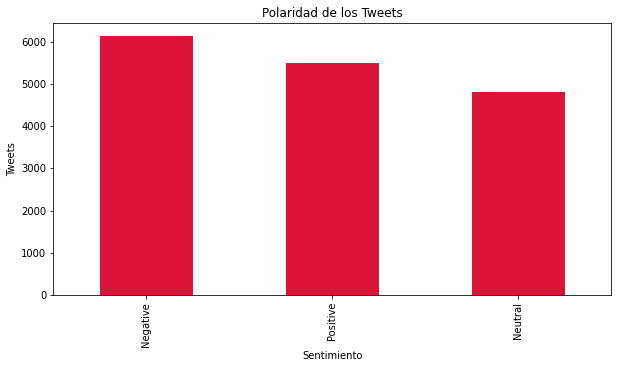

In [39]:
# Visualizamos la polaridad de categorización reducida
plt.figure(figsize=(10,5)) 
df2['sentiment'].value_counts().plot(kind='bar',color = 'crimson')
plt.xlabel('Sentimiento')
plt.ylabel('Tweets')
plt.title('Polaridad de los Tweets')

In [40]:
df2['sentiment_mc'].value_counts()

N       5003
P       4748
NONE    3107
NEU     1706
N+      1132
P+       744
Name: sentiment_mc, dtype: int64

Text(0.5, 1.0, 'Polaridad de los Tweets con MeaningCloud')

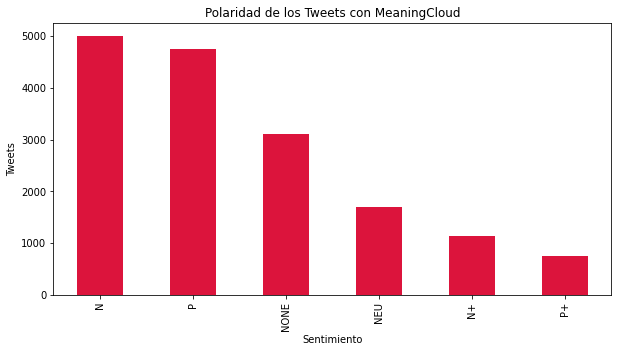

In [41]:
plt.figure(figsize=(10,5)) 
df2['sentiment_mc'].value_counts().plot(kind='bar', color = 'crimson')
plt.xlabel('Sentimiento')
plt.ylabel('Tweets')
plt.title('Polaridad de los Tweets con MeaningCloud')

Text(0.5, 1.0, 'Polaridad de los Tweets con MeaningCloud')

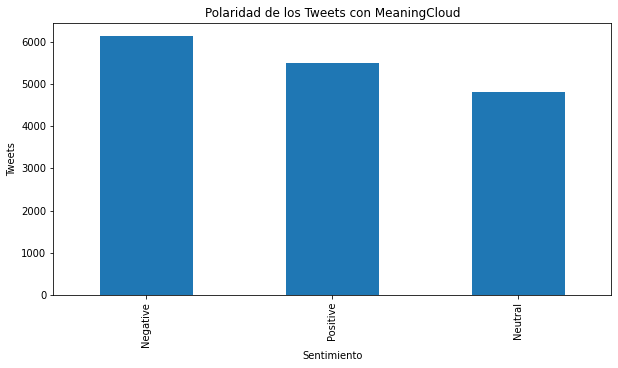

In [42]:
plt.figure(figsize=(10,5)) 
df2['sentiment'].value_counts().plot(kind='bar')
plt.xlabel('Sentimiento')
plt.ylabel('Tweets')
plt.title('Polaridad de los Tweets con MeaningCloud')

In [43]:
df2['sentiment'].value_counts()

Negative    6135
Positive    5492
Neutral     4813
Name: sentiment, dtype: int64

In [44]:
# WORDCLOUD

from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

stop_words_sp = stopwords.words('spanish')
newStopWords = ['si','así','amp','hoy','ahora','día','ser','tan','bolivia','va','año','siempre','creo','debe','toda']
stop_words_sp.extend(newStopWords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


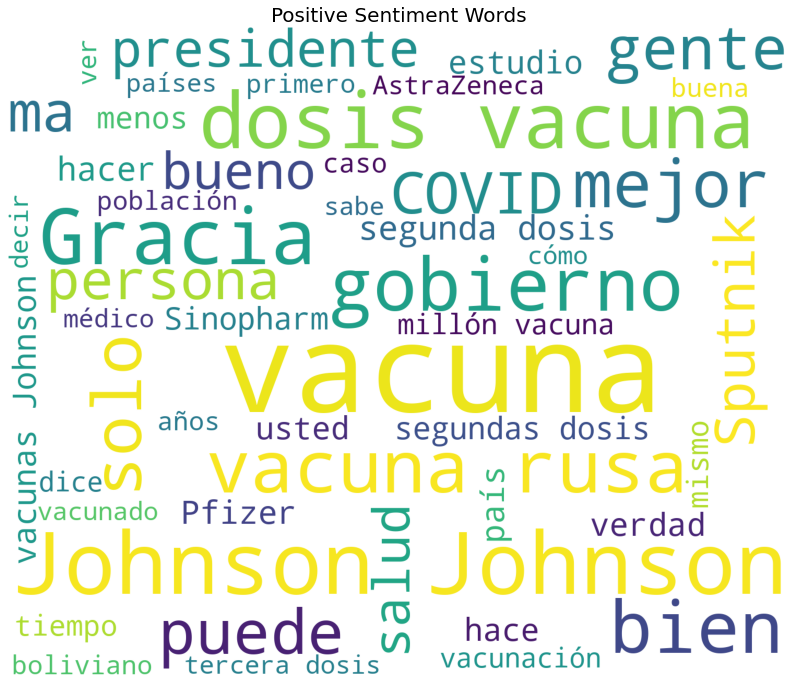

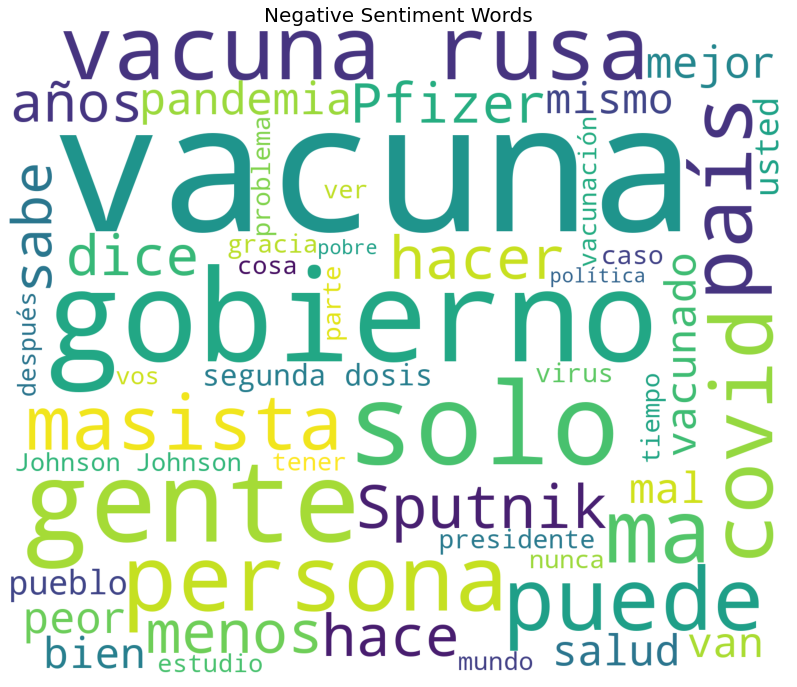

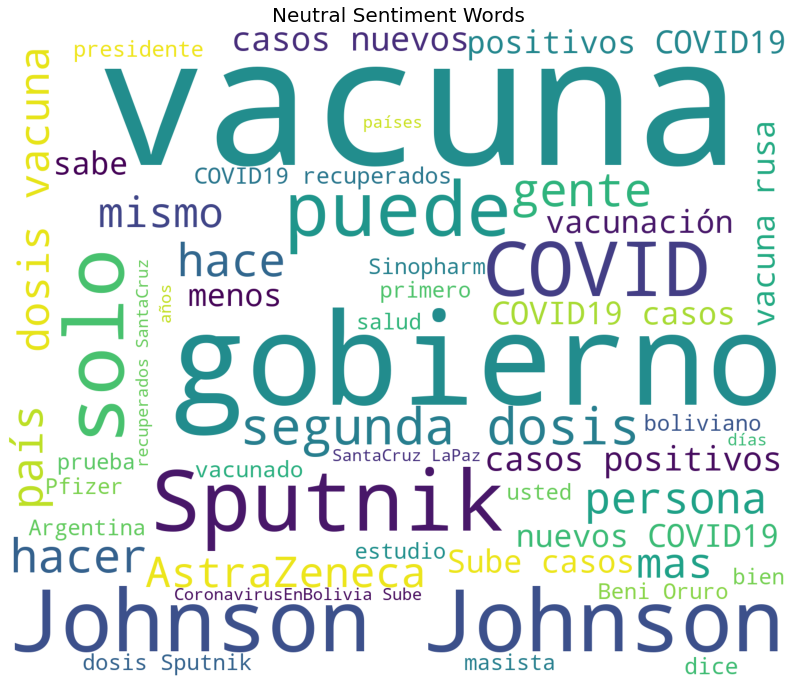

In [45]:
def wordcount_gen(df, sentiment):
    combined_tweets = " ".join([tweet for tweet in df2[df2['sentiment']==sentiment]['content_clean']])
    wc = WordCloud(background_color='white', 
                    max_words=50, 
                    width=1500,
                    height=1250,
                    stopwords = stop_words_sp)

    plt.figure(figsize=(15,12))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(sentiment), fontsize=20)
    plt.axis('off')
    plt.show()
    
# Positive tweet words
wordcount_gen(df2, 'Positive')
     
# Negative tweet words
wordcount_gen(df2, 'Negative')
     
# Neutral tweet words
wordcount_gen(df2, 'Neutral')

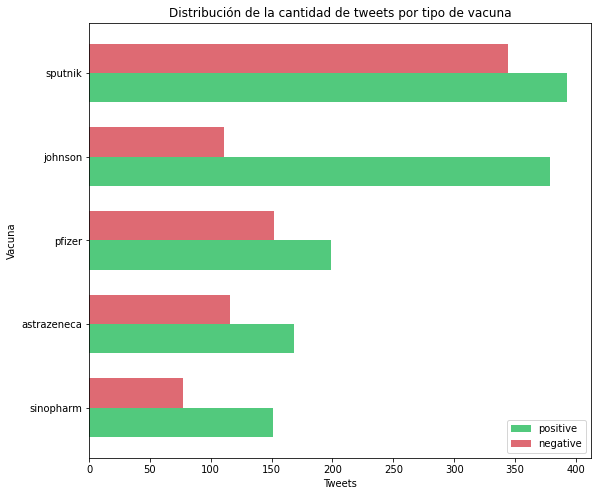

In [46]:
import matplotlib.pyplot as plt

# CLASIFICACION POR VACUNA
vaccines = ['sputnik', 'sinopharm', 'pfizer', 'astrazeneca', 'johnson']

nd = pd.DataFrame(vaccines, columns=['vaccine'])

nd['total'] = 0
nd['positive'] = 0
nd['negative'] = 0
nd['neutral'] = 0

df2['content_clean'] = df2['content_clean'].apply(lambda x: str(x).lower())

for i,v in enumerate(vaccines):  
  tmp = df2[df2['content_clean'].str.contains(v)]
  nd['total'][i] = tmp.shape[0]
  nd['positive'][i] = tmp[tmp['sentiment'] == 'Positive'].shape[0]
  nd['negative'][i] = tmp[tmp['sentiment'] == 'Negative'].shape[0]
  nd['neutral'][i] = tmp[tmp['sentiment'] == 'Neutral'].shape[0]

nd = nd.sort_values(['total'], ascending=True)
# nd.head()

my_colors = ['#52c97d', '#de6a73']
fg = nd.plot(x="vaccine", y=["positive", "negative"], kind="barh",figsize=(9,8), color=my_colors, align='center', width=0.70)
plt.xlabel('Tweets')
plt.ylabel('Vacuna')
plt.title('Distribución de la cantidad de tweets por tipo de vacuna')
plt.show()

In [47]:
import numpy as np

# Obtenemos la información de ubicación dentro del territorio Boliviano de los tweets
def check_location(x):
    if 'santacruz' in str(x).lower() or 'sta cruz' in str(x).lower() or 'santa cruz' in str(x).lower() or 'scz' in str(x).lower() or 'montero' in str(x).lower():
        return 'Santa Cruz'
    if 'la paz' in str(x).lower() or 'lapaz' in str(x).lower() or 'lpz' in str(x).lower() or 'el alto' in str(x).lower() or 'elalto' in str(x).lower():
        return 'La Paz'
    if 'cochabamba' in str(x).lower() or 'cbba' in str(x).lower() or 'cba' in str(x).lower() or 'cocha' in str(x).lower() or 'llajta' in str(x).lower() or 'tunari' in str(x).lower():
        return 'Cochabamba'
    if 'tarija' in str(x).lower() or 'tja' in str(x).lower() or 'villa montes' in str(x).lower() or 'yacuiba' in str(x).lower():
        return 'Tarija'
    if 'chuquisaca' in str(x).lower() or 'sucre' in str(x).lower() or 'chq' in str(x).lower():
        return 'Chuquisaca'
    if 'oruro' in str(x).lower() or 'oru' in str(x).lower():
        return 'Oruro'
    if 'potosi' in str(x).lower() or 'potosí' in str(x).lower() or 'pts' in str(x).lower():
        return 'Potosí'
    if 'beni' in str(x).lower() or 'ben' in str(x).lower() or 'rurrenabaque' in str(x).lower() or 'trinidad' in str(x).lower() or 'riberalta' in str(x).lower():
        return 'Beni'
    if 'pando' in str(x).lower() or 'pnd' in str(x).lower() or 'cobija' in str(x).lower():
        return 'Pando'

df2['location'] = np.nan
df2['location'] = df2['user_location'].apply(lambda x: check_location(x))

# De los valores restante obtenemos los que aún pertenezcan dentro Bolivia en general
df_location = df2[df2['location'].isna()]
for i in df_location.index:
  if 'bolivia' in str(df_location['user_location'][i]).lower() or 'bolivia' in str(df_location['place_country'][i]).lower():
    df2['location'][i] = 'Bolivia'

df2['location'].value_counts()

Bolivia       3023
La Paz         833
Santa Cruz     543
Cochabamba     281
Chuquisaca      92
Tarija          58
Oruro           42
Pando           17
Beni            16
Potosí           7
Name: location, dtype: int64

In [48]:
import csv
df2.to_csv('cleanedBIDataset2.csv', index=False)